# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### План работ

 1. Подготовьте данные
 2. Проанализируйте данные
 3. Постройте модель
 

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
pd.set_option("display.max_columns",100)

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
gold_recovery_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
gold_recovery_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [6]:
gold_recovery_train['calculated_rougher.output.recovery'] = ((gold_recovery_train['rougher.output.concentrate_au']
                                                      * (gold_recovery_train['rougher.input.feed_au']
                                                         - gold_recovery_train['rougher.output.tail_au']))
                                                     /(gold_recovery_train['rougher.input.feed_au']
                                                       * (gold_recovery_train['rougher.output.concentrate_au']
                                                          - gold_recovery_train['rougher.output.tail_au'])) *100)

In [7]:
gold_recovery_train[['calculated_rougher.output.recovery','rougher.output.recovery']].head()

,calculated_rougher.output.recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Удалим все строки, в которых присутсвуют пропуски на месте эффективности обогащения на этапе флотации. Заменить на на что-либо нет возможности.

In [8]:
gold_recovery_train = (gold_recovery_train
                       .dropna(subset=['rougher.output.recovery', 'calculated_rougher.output.recovery']))

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
print('MAE:', 
      mean_squared_error(gold_recovery_train['rougher.output.recovery'], 
                         gold_recovery_train['calculated_rougher.output.recovery']))

MAE: 2.0435431534920925e-28


Среднее абсолютное отклонение близко к 0, значит эффективность обогащения посчитана верно.

Изучим признаки из обучающей выборки, которые отсутсвуют в тестовой.

In [11]:
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [12]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [13]:
gold_recovery_train[gold_recovery_train
                    .columns[~gold_recovery_train
                             .columns
                             .isin(gold_recovery_test
                                   .columns)]].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,calculated_rougher.output.recovery
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,41885.707031,3481.779053,3520.337158,2.838687,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185,87.107763
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,42050.861809,3498.370979,3489.981857,2.858998,11.615865,7.278807,28.067063,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248,86.843261
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,10.354494,19.167579,33.969464,16.491823,3.124664,6.471768,2.416800,42018.101184,3495.348910,3502.359819,2.945989,11.695753,7.216833,27.454037,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187,86.842308
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,8.496563,15.978538,28.260743,16.024359,2.960362,6.843791,2.262051,42029.447991,3498.578313,3499.162912,3.002340,11.915047,7.175616,27.341277,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062,87.226430
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,9.986786,19.199864,33.044932,16.480185,3.112100,6.550154,2.277073,42125.354245,3494.800771,3506.679315,3.169615,12.411054,7.240205,27.041023,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448,86.688794


In [14]:
gold_recovery_train[gold_recovery_train
                    .columns[~gold_recovery_train
                             .columns
                             .isin(gold_recovery_test
                                   .columns)]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 35 columns):
final.output.concentrate_ag                           14282 non-null float64
final.output.concentrate_pb                           14282 non-null float64
final.output.concentrate_sol                          14055 non-null float64
final.output.concentrate_au                           14283 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14287 non-null float64
final.output.tail_pb                                  14173 non-null float64
final.output.tail_sol                                 14279 non-null float64
final.output.tail_au                                  14287 non-null float64
primary_cleaner.output.concentrate_ag                 14287 non-null float64
primary_cleaner.output.concentrate_pb                 14164 non-null float64
primary_cleaner.output.concentrate_sol      

Как можно заметить, в основном, в тестовом наборе данных отсутсвуют выходные характеристики каждого этапа. Это категориальные данные.

Это обусловленно тем, что тестовые данные еще не проходил через процесс востановления золота. Также нет расчетных характеристик (таких, как <code>rougher.calculation.sulfate_to_au_concentrate</code>).

Также в gold_recovery_test нет целевых признаков. В дальнейшем, я думаю, можно будет подтянуть их из полного датасета для проверки.

Посмотрим на пропуски. 

In [15]:
gold_recovery_train.isna().sum().sort_values(ascending=False).head(40)

secondary_cleaner.output.tail_sol             1654
rougher.state.floatbank10_e_air                438
rougher.input.floatbank11_xanthate             434
primary_cleaner.output.concentrate_sol         338
final.output.concentrate_sol                   232
secondary_cleaner.state.floatbank2_a_air       219
rougher.input.feed_size                        149
final.output.recovery                          138
rougher.input.feed_pb                          123
primary_cleaner.output.concentrate_pb          123
final.output.tail_pb                           114
primary_cleaner.input.xanthate                 105
rougher.input.feed_sol                          96
primary_cleaner.output.tail_sol                 79
rougher.input.floatbank11_sulfate               38
primary_cleaner.input.depressant                38
rougher.input.floatbank10_sulfate               31
rougher.output.concentrate_sol                  26
primary_cleaner.input.sulfate                   26
secondary_cleaner.state.floatba

Дропнем все строчки, где нет значений в <code>final.output.recovery</code>, а остальные пропуски я решил заполнить методом ffill. Он заполняет пропуски последним значением, которое предшествовало NaN.

In [16]:
gold_recovery_train = gold_recovery_train[~gold_recovery_train['final.output.recovery'].isna()]

In [17]:
gold_recovery_train = gold_recovery_train.fillna(method='ffill')

In [18]:
gold_recovery_train.isna().sum().sort_values(ascending=False).head(10)

calculated_rougher.output.recovery               0
secondary_cleaner.state.floatbank6_a_level       0
primary_cleaner.state.floatbank8_a_level         0
primary_cleaner.state.floatbank8_b_air           0
primary_cleaner.state.floatbank8_b_level         0
primary_cleaner.state.floatbank8_c_air           0
primary_cleaner.state.floatbank8_c_level         0
primary_cleaner.state.floatbank8_d_air           0
primary_cleaner.state.floatbank8_d_level         0
rougher.calculation.sulfate_to_au_concentrate    0
dtype: int64

In [19]:
gold_recovery_test = gold_recovery_test.fillna(method='ffill')

In [20]:
gold_recovery_test.isna().sum().sort_values(ascending=False).head(10)

secondary_cleaner.state.floatbank6_a_level    0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_a_air               0
rougher.input.floatbank11_xanthate            0
rougher.input.floatbank11_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank10_sulfate             0
rougher.input.feed_au                         0
rougher.input.feed_sol                        0
rougher.input.feed_size                       0
dtype: int64

В конце дропнем строчки с датой.

In [21]:
gold_recovery_train = gold_recovery_train.drop('date', axis=1)
gold_recovery_test_date = gold_recovery_test['date']
gold_recovery_test = gold_recovery_test.drop('date', axis=1)

## Выводы

Данные изучены. В выборках заполненны пропуски и можно приступать к более детальному анализу данных.

# 2. Анализ данных

Рассмотрим изменения разных металов на каждом этапе очистки.

In [22]:
import matplotlib.pyplot as plt

In [23]:
sns.set(font_scale=(1.2), style='whitegrid', rc={'grid.linestyle':'--'})

In [24]:
def plot_change_ore_concentrate(data, columns=[], metal_name='?'):
    
    means = []
    x = [0,1,2]
    for column in columns:
        means.append(data[column].mean())
                     
    means = pd.Series(means)
    
    fig, ax = plt.subplots(figsize=(13,7))
    sns.lineplot(x=means.index, y=means, ax=ax)
    ax.set_title('Изменение содержания {}'.format(metal_name))
    plt.xticks(x,columns)
    plt.yticks(means)
    plt.ylabel('Концентрация')
    plt.xlabel('Этап')

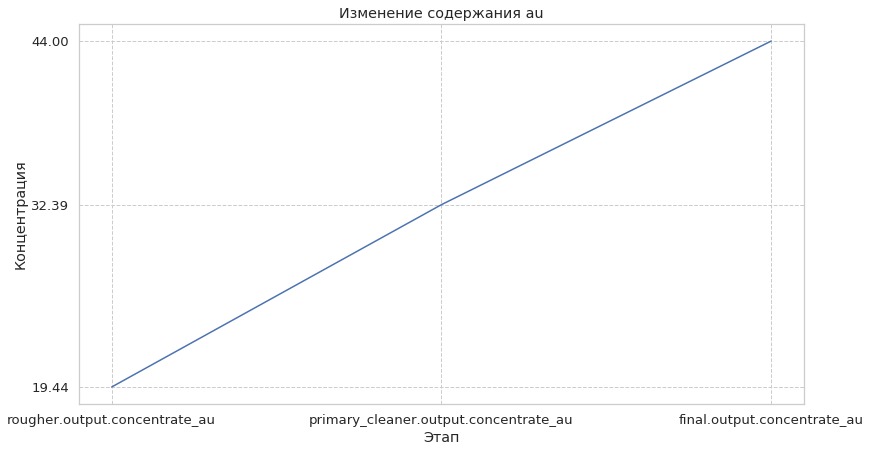

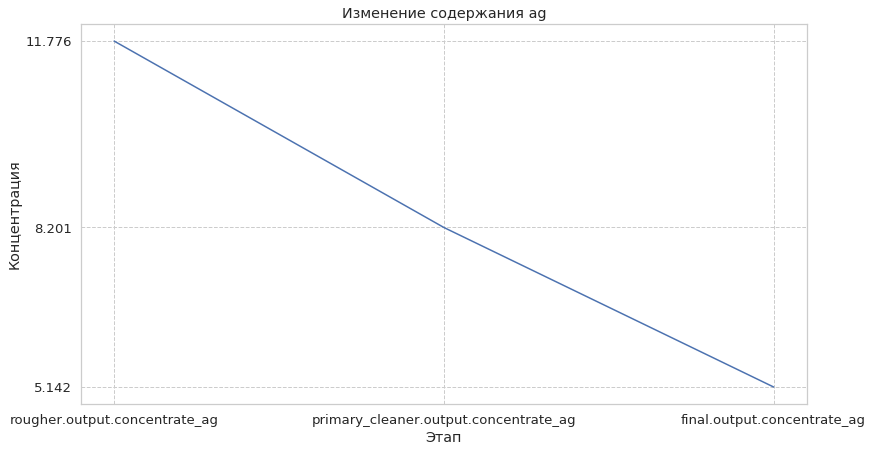

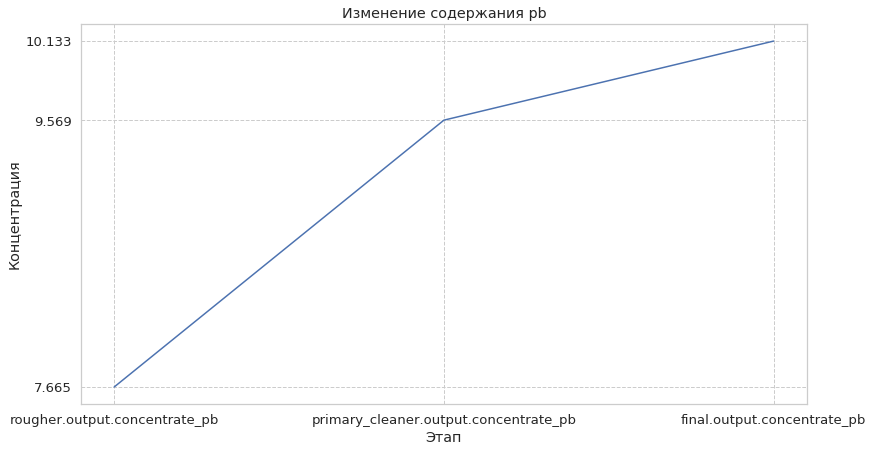

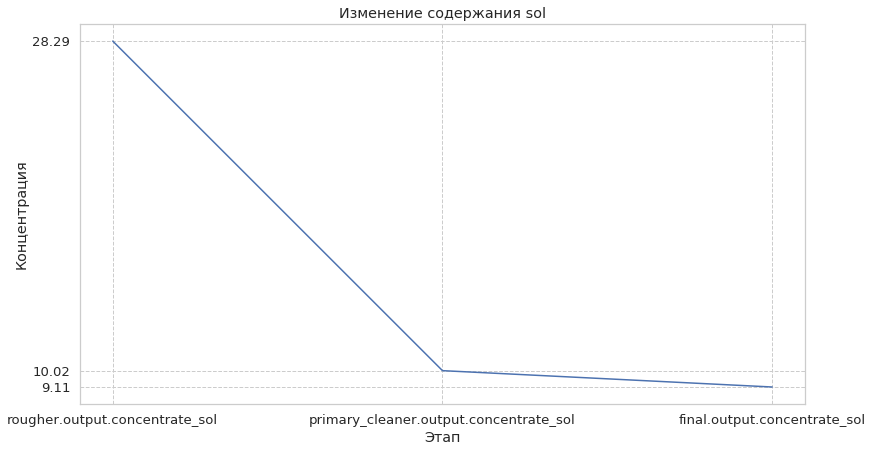

In [25]:
column_set = [['rougher.output.concentrate_au',
               'primary_cleaner.output.concentrate_au',
               'final.output.concentrate_au'],
              ['rougher.output.concentrate_ag',
               'primary_cleaner.output.concentrate_ag',
               'final.output.concentrate_ag'],
              ['rougher.output.concentrate_pb',
               'primary_cleaner.output.concentrate_pb',
               'final.output.concentrate_pb'],               
              ['rougher.output.concentrate_sol',
               'primary_cleaner.output.concentrate_sol',
               'final.output.concentrate_sol']]

for columns, name in zip(range(len(column_set)),
                         ['au', 'ag', 'pb', 'sol']):
    plot_change_ore_concentrate(gold_recovery_train,
                           columns=column_set[columns],
                           metal_name=name)

Концентрация свинца(Pb) и золота(Au) растет, тогда как содержания серебра(Ag) падает. Что такое sol, я не знаю, есть предположение, что это остальные примеси или раствор(solution). Но его концентрация резко падает первой очистки.

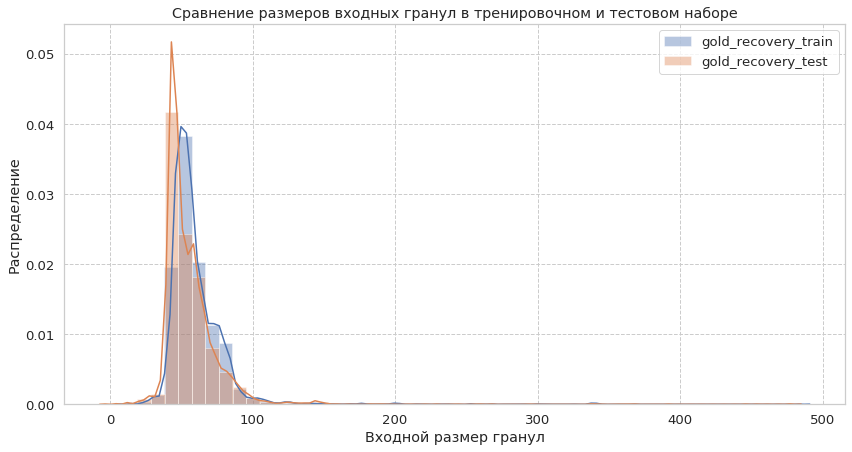

In [26]:
fig, ax = plt.subplots(figsize=(14,7))
sns.distplot(gold_recovery_train['rougher.input.feed_size'])
sns.distplot(gold_recovery_test['rougher.input.feed_size'])
plt.ylabel('Распределение')
plt.xlabel('Входной размер гранул')
ax.set_title('Сравнение размеров входных гранул в тренировочном и тестовом наборе')
plt.legend(['gold_recovery_train','gold_recovery_test'])

Распределения практически совпадают. Значит можно проводить обучение на тренеровочном наборе данных для предсказания результатов тестовой выборки

Далее в задании идет пункт "2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии."

Я еще не сталкивался с заданием по обнаружению аномалий или, по крайней мере, с такой формалировкой. Поэтому я решил строки, где присутсвуют нули изходя из логики: вероятней всего получить нулевую концентрацию веществ в процессе невозможно и все нулевые результаты с нулевым содержанием веществ отсеиваются на начальном, черновом(rougher) этапе.

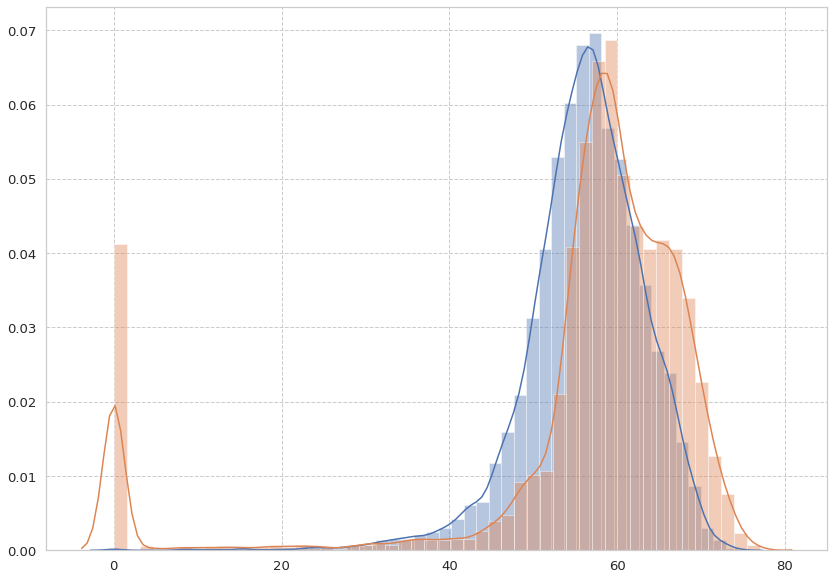

In [27]:
column_set = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']


fig, axes = plt.subplots(figsize=(14,10))
sns.distplot(gold_recovery_train[column_set].T.sum(), ax=axes)
sns.distplot(gold_recovery_test[column_set].T.sum(), ax=axes)

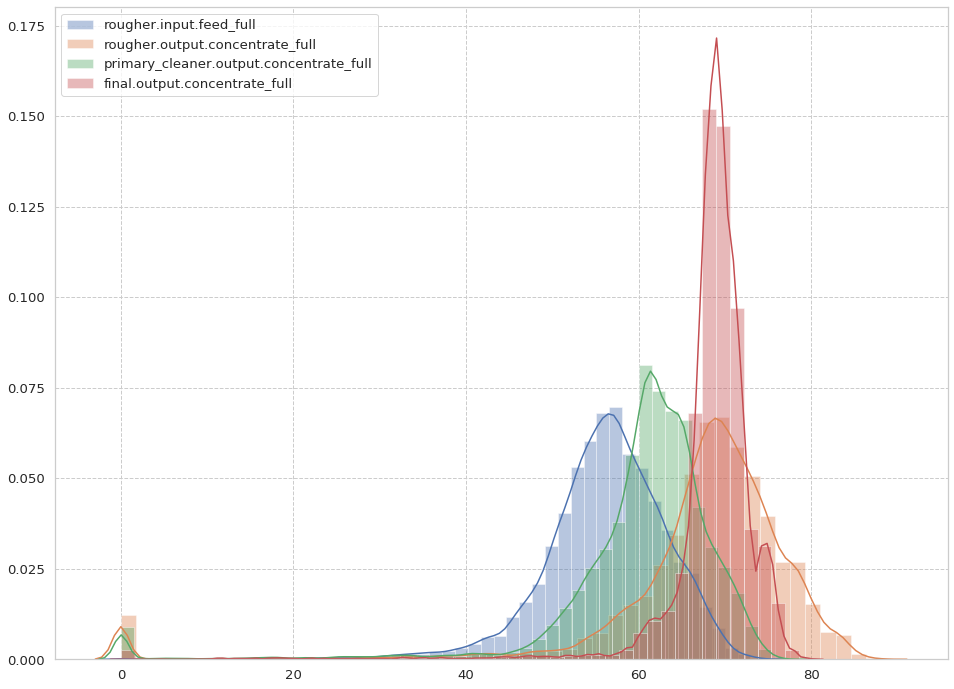

In [28]:
column_set_0 = ['rougher.input.feed_ag',
                'rougher.input.feed_pb',
                'rougher.input.feed_sol',
                'rougher.input.feed_au']
column_set_1 = ['rougher.output.concentrate_ag',
                'rougher.output.concentrate_pb',
                'rougher.output.concentrate_sol',
                'rougher.output.concentrate_au']
column_set_2 = ['primary_cleaner.output.concentrate_ag',
                'primary_cleaner.output.concentrate_pb',
                'primary_cleaner.output.concentrate_sol',
                'primary_cleaner.output.concentrate_au']
column_set_3 = ['final.output.concentrate_ag',
                'final.output.concentrate_pb',
                'final.output.concentrate_sol',
                'final.output.concentrate_au']

fig, axes = plt.subplots( figsize=(16,12))

sns.distplot(gold_recovery_train[column_set_0].sum(axis=1), ax=axes)
sns.distplot(gold_recovery_train[column_set_1].sum(axis=1), ax=axes)
sns.distplot(gold_recovery_train[column_set_2].sum(axis=1), ax=axes)
sns.distplot(gold_recovery_train[column_set_3].sum(axis=1), ax=axes)

plt.legend(['rougher.input.feed_full','rougher.output.concentrate_full', 'primary_cleaner.output.concentrate_full', 'final.output.concentrate_full'])

gold_recovery_train['rougher.input.feed_full'] = gold_recovery_train[column_set_0].sum(axis=1)
gold_recovery_train['rougher.output.concentrate_full'] = gold_recovery_train[column_set_1].sum(axis=1)
gold_recovery_train['primary_cleaner.output.concentrate_full'] = gold_recovery_train[column_set_2].sum(axis=1)
gold_recovery_train['final.output.concentrate_full'] = gold_recovery_train[column_set_3].sum(axis=1)

Сходу аномалий не видно. Нуливые значени не являются сами по себе аномалиями, однако они могут в них учавствовать. Проверим это.

In [29]:
gold_recovery_train[(gold_recovery_train['rougher.output.concentrate_ag']==0) | (gold_recovery_train['primary_cleaner.output.concentrate_ag']==0) | (gold_recovery_train['final.output.concentrate_ag']==0)][['rougher.input.feed_full', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

,rougher.input.feed_full,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
19,56.005644,10.788951,0.000000,5.658943
22,56.038252,10.958096,0.000000,6.118749
30,57.764677,11.574823,0.000000,5.322681
45,58.602038,0.000000,8.513177,4.566664
46,59.921613,0.000000,8.466262,4.577832
...,...,...,...,...
12360,58.106496,0.000000,8.978113,4.909904
12361,59.500740,0.000000,8.951252,4.797572
12362,60.129638,0.000000,8.377929,4.329492
12363,59.267147,0.000000,8.599144,4.317169


Концентрация вещества меняется, и это нормально. Однако когда из нулеывого значения она становится, на пример, 8, то это ужа аномалия. Также получение нуля в конце поцесса - это тоже анамалия. Предлагаю дропнуть все нули.

##### <i>Я ломал голову над тем, что подразумевается по аномалией, придумал только это. Поясните, пожалуйста, что именно требуется в задании?</i>

In [30]:
gold_recovery_train.shape

(14149, 91)

In [31]:
gold_recovery_train = gold_recovery_train[~((gold_recovery_train['rougher.output.concentrate_ag']==0) |
                                            (gold_recovery_train['primary_cleaner.output.concentrate_ag']==0) |
                                            (gold_recovery_train['final.output.concentrate_ag']==0))]

In [32]:
gold_recovery_train.shape

(13725, 91)

Удаляем добавленные столбцы, так как они могут помешать обучению.

In [33]:
gold_recovery_train = gold_recovery_train.drop(['rougher.input.feed_full', 'rougher.output.concentrate_full', 'primary_cleaner.output.concentrate_full', 'final.output.concentrate_full'], axis=1)

## Выводы

В данном пункте были проанализированны этапы очистки металов и суммарное количество вещества на разных этапах. Также были сравненны распределения обеих выборок для подтверждения того, что модель, обученая на тренировочной выборке, сможет сделать правильную оценку тестовой выборки. Были удалены аномалии.(нули в концентрации вещества).

# 3. Модель

Функция расчета sMAPE.

In [35]:
def smape(target, predicted):
    return (sum(abs(target - predicted) / ((abs(target) + abs(predicted)) / 2))) / len(target) * 100

Выделим отдельно целевые признаки.

In [36]:
features = gold_recovery_train[gold_recovery_train
                    .columns[gold_recovery_train
                             .columns
                             .isin(gold_recovery_test
                                   .columns)]]

In [37]:
target = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]

Скалируем остальные признаки, для повышения точности. 

In [38]:
scal=StandardScaler()
scal.fit(features)
features = scal.transform(features)

### Линейная регрессия

Создаем и обучаем модель.

In [39]:
model_rougher_recovery = LinearRegression()
model_final_recovery = LinearRegression()

Проверим точность предсказания модели кросс-валидацией. В данном случае воспользуемся <code>cross_valid_predict()</code>. Он возвращает предсказания для каждого объекта, когда тот был в валидационной выборке. cross_val_score просто считает метрику R2, тогда как у нас есть sMAPE.

In [41]:
rougher_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['rougher.output.recovery'], cv=5)
final_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['final.output.recovery'], cv=5)
final_recovery_smape = smape(target['final.output.recovery'], final_recovery_predict)
rougher_recovery_smape = smape(target['rougher.output.recovery'], rougher_recovery_predict)
final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25

In [42]:
rougher_recovery_smape

7.265696047566006

In [43]:
final_recovery_smape

10.950532500993184

In [44]:
final_smape

10.029323387636389

### Градиентный спуск

In [45]:
model_rougher_recovery = GradientBoostingRegressor(random_state=12)
model_final_recovery = GradientBoostingRegressor(random_state=15)

In [46]:
rougher_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['rougher.output.recovery'], cv=5)
final_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['final.output.recovery'], cv=5)

final_recovery_smape = smape(target['final.output.recovery'], final_recovery_predict)
rougher_recovery_smape = smape(target['rougher.output.recovery'], rougher_recovery_predict)
final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25

In [47]:
rougher_recovery_smape

6.31375835983444

In [48]:
final_recovery_smape

9.54522798772498

In [49]:
final_smape

8.737360580752345

### Случайный лес

Создаем и обучаем модель.

In [50]:
model_rougher_recovery = RandomForestRegressor(random_state=12)
model_final_recovery = RandomForestRegressor(random_state=15)

In [51]:
rougher_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['rougher.output.recovery'], cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [52]:
rougher_recovery_smape = smape(target['rougher.output.recovery'], rougher_recovery_predict)

In [53]:
final_recovery_predict = cross_val_predict(model_rougher_recovery, features, target['final.output.recovery'], cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [54]:
final_recovery_smape = smape(target['final.output.recovery'], final_recovery_predict)

In [55]:
final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25

In [56]:
rougher_recovery_smape

7.15038747420142

In [57]:
final_recovery_smape

10.68371393040169

In [58]:
final_smape

9.800382316351623

Подбкрем гиперпараметры для случайного леса и градиентного спуска.

In [59]:
model_rougher_recovery = GradientBoostingRegressor(random_state=12)
model_final_recovery = GradientBoostingRegressor(random_state=15)

In [60]:
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.25, random_state=13)

In [61]:
estims = 400
for estim in range(1,estims, 50):
    model_rougher_recovery = GradientBoostingRegressor(random_state=12, n_estimators=estim)
    model_final_recovery = GradientBoostingRegressor(random_state=15, n_estimators=estim)
    model_rougher_recovery.fit(train_features, train_target['rougher.output.recovery'])
    model_final_recovery.fit(train_features, train_target['final.output.recovery'])
    
    rougher_recovery_smape = smape(valid_target['rougher.output.recovery'],  model_rougher_recovery.predict(valid_features))
    final_recovery_smape = smape(valid_target['final.output.recovery'], model_final_recovery.predict(valid_features))
    final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25
    print(estim)
    print(final_smape)

1
8.929329341926142
51
6.411783459718081
101
6.110323625870379
151
5.933523013303826
201
5.820727411857609
251
5.70929479402045
301
5.648802681604853
351
5.580891318239252


In [62]:
estims = 300
for estim in range(1,estims, 50):
    model_rougher_recovery = RandomForestRegressor(random_state=12, n_estimators=estim, n_jobs=-1)
    model_final_recovery = RandomForestRegressor(random_state=15, n_estimators=estim, n_jobs=-1)
    model_rougher_recovery.fit(train_features, train_target['rougher.output.recovery'])
    model_final_recovery.fit(train_features, train_target['final.output.recovery'])
    
    rougher_recovery_smape = smape(valid_target['rougher.output.recovery'],  model_rougher_recovery.predict(valid_features))
    final_recovery_smape = smape(valid_target['final.output.recovery'], model_final_recovery.predict(valid_features))
    final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25
    print(estim)
    print(final_smape)
    

1
7.653086255392525
51
5.066463724941198
101
5.017524876501473
151
5.0040206094138435
201
5.000550026018088
251
5.004603013511567


Лучший результат показал Случайный лес.

Оптимальным решением будет выбор 150 деревьев, так как после sMAPE не так сильно изменяется, однако вырастает время работы.

Теперь обучим модели на полной выборке и предскажем результаты на тестовой.

In [63]:
model_rougher_recovery = RandomForestRegressor(random_state=12, n_estimators=150, n_jobs=-1)
model_final_recovery = RandomForestRegressor(random_state=15, n_estimators=150, n_jobs=-1)
model_rougher_recovery.fit(features, target['rougher.output.recovery'])
model_final_recovery.fit(features, target['final.output.recovery'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                      oob_score=False, random_state=15, verbose=0,
                      warm_start=False)

In [64]:
test_features = scal.transform(gold_recovery_test)

In [65]:
test_rougher_prediction = model_rougher_recovery.predict(test_features)
test_final_prediction = model_final_recovery.predict(test_features)

Осталось проверить результат, взям данные из полного датасета. для этого используем столбец с датой как индекс. Также, пришлось удалить результаты данных о recovery которых нет в исходной таблице.

In [66]:
gold_recovery_true = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test_date)][['rougher.output.recovery', 'final.output.recovery', 'date']]

In [67]:
test_rougher_prediction = pd.DataFrame({'test_rougher_prediction' : test_rougher_prediction, 'test_final_prediction' : test_final_prediction,'date' : gold_recovery_test_date})

In [68]:
test_rougher_prediction

,test_rougher_prediction,test_final_prediction,date
0,88.432013,67.794795,2016-09-01 00:59:59
1,87.803676,68.540915,2016-09-01 01:59:59
2,87.593179,68.178270,2016-09-01 02:59:59
3,87.009965,69.723632,2016-09-01 03:59:59
4,87.189860,69.226250,2016-09-01 04:59:59
...,...,...,...
5851,82.719407,69.883496,2017-12-31 19:59:59
5852,85.605475,68.945318,2017-12-31 20:59:59
5853,92.541637,71.991224,2017-12-31 21:59:59
5854,93.472356,73.435016,2017-12-31 22:59:59


In [69]:
test_rougher_prediction = test_rougher_prediction[~test_rougher_prediction['date'].isin(gold_recovery_true[gold_recovery_true['rougher.output.recovery'].isna() | gold_recovery_true['final.output.recovery'].isna()]['date']) ].reset_index(drop=True)

In [70]:
gold_recovery_test_date = gold_recovery_test_date.reset_index(drop=True)

In [71]:
gold_recovery_true = gold_recovery_true.dropna().reset_index(drop=True)

In [72]:
gold_recovery_true

,rougher.output.recovery,final.output.recovery,date
0,89.993421,70.273583,2016-09-01 00:59:59
1,88.089657,68.910432,2016-09-01 01:59:59
2,88.412756,68.143213,2016-09-01 02:59:59
3,87.360133,67.776393,2016-09-01 03:59:59
4,83.236367,61.467078,2016-09-01 04:59:59
...,...,...,...
5285,95.172585,68.919891,2017-12-31 19:59:59
5286,94.575036,68.440582,2017-12-31 20:59:59
5287,93.018138,67.092759,2017-12-31 21:59:59
5288,92.599042,68.061186,2017-12-31 22:59:59


In [73]:
test_rougher_prediction

,test_rougher_prediction,test_final_prediction,date
0,88.432013,67.794795,2016-09-01 00:59:59
1,87.803676,68.540915,2016-09-01 01:59:59
2,87.593179,68.178270,2016-09-01 02:59:59
3,87.009965,69.723632,2016-09-01 03:59:59
4,87.189860,69.226250,2016-09-01 04:59:59
...,...,...,...
5285,82.719407,69.883496,2017-12-31 19:59:59
5286,85.605475,68.945318,2017-12-31 20:59:59
5287,92.541637,71.991224,2017-12-31 21:59:59
5288,93.472356,73.435016,2017-12-31 22:59:59


In [74]:
gold_recovery_true.isna().sum()

rougher.output.recovery    0
final.output.recovery      0
date                       0
dtype: int64

In [75]:
rougher_recovery_smape = smape(gold_recovery_true['rougher.output.recovery'], test_rougher_prediction['test_rougher_prediction'])

In [76]:
rougher_recovery_smape

7.942487141195685

In [77]:
final_recovery_smape = smape(gold_recovery_true['final.output.recovery'], test_rougher_prediction['test_final_prediction'])

In [78]:
final_recovery_smape

9.724850021918082

In [79]:
final_smape = final_recovery_smape * 0.75 + rougher_recovery_smape * 0.25

In [80]:
final_smape

9.279259301737483

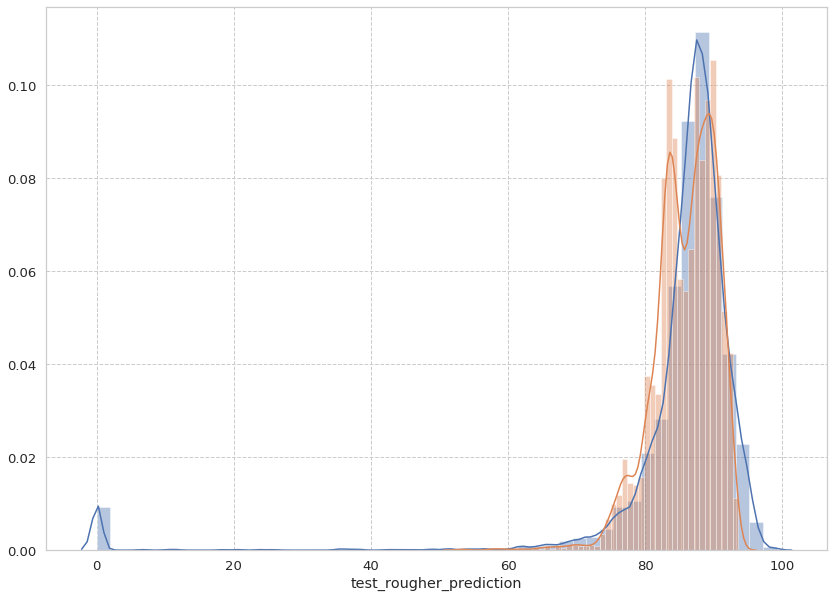

In [81]:
fig, ax =plt.subplots(figsize=(14,10))
sns.distplot(gold_recovery_true['rougher.output.recovery'])
sns.distplot(test_rougher_prediction['test_rougher_prediction'])

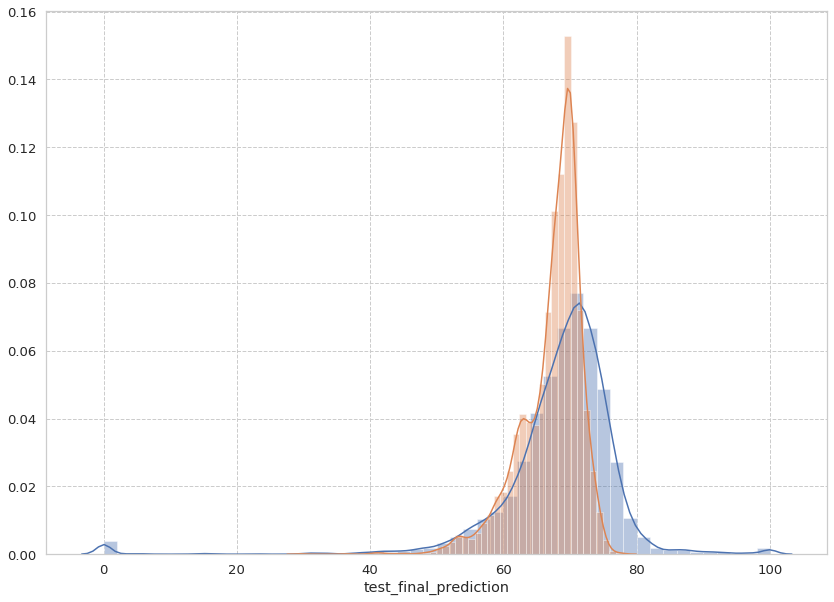

In [82]:
fig, ax =plt.subplots(figsize=(14,10))
sns.distplot(gold_recovery_true['final.output.recovery'])
sns.distplot(test_rougher_prediction['test_final_prediction'])

# Сравнение с константной моделью

In [83]:
from sklearn.dummy import DummyRegressor

In [84]:
dummy_rougher_recovery = DummyRegressor(strategy="mean")
dummy_final_recovery = DummyRegressor(strategy="mean")
dummy_rougher_recovery.fit(features, target['rougher.output.recovery'])
dummy_final_recovery.fit(features, target['final.output.recovery'])

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [85]:
dummy_rougher_prediction = dummy_rougher_recovery.predict(test_features)
dummy_final_prediction = dummy_final_recovery.predict(test_features)

In [86]:
dummy_prediction = pd.DataFrame({'test_rougher_prediction' : dummy_rougher_prediction, 'test_final_prediction' : dummy_final_prediction,'date' : gold_recovery_test_date})

In [87]:
dummy_prediction

,test_rougher_prediction,test_final_prediction,date
0,84.5087,66.808927,2016-09-01 00:59:59
1,84.5087,66.808927,2016-09-01 01:59:59
2,84.5087,66.808927,2016-09-01 02:59:59
3,84.5087,66.808927,2016-09-01 03:59:59
4,84.5087,66.808927,2016-09-01 04:59:59
...,...,...,...
5851,84.5087,66.808927,2017-12-31 19:59:59
5852,84.5087,66.808927,2017-12-31 20:59:59
5853,84.5087,66.808927,2017-12-31 21:59:59
5854,84.5087,66.808927,2017-12-31 22:59:59


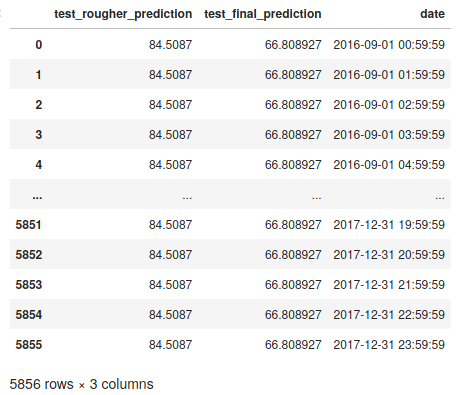

In [ ]:
dummy_prediction = dummy_prediction[~dummy_prediction['date'].isin(gold_recovery_true_dummy[gold_recovery_true_dummy['rougher.output.recovery'].isna() | gold_recovery_true_dummy['final.output.recovery'].isna()]['date'])].reset_index(drop=True)

In [ ]:
dummy_prediction

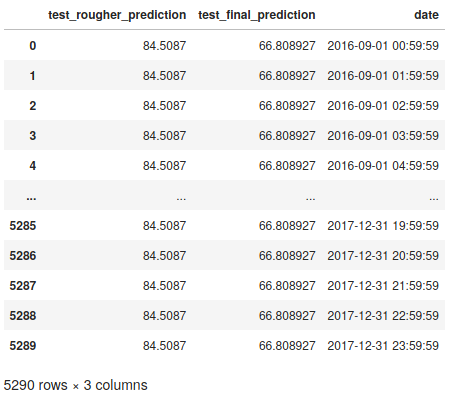

In [ ]:
gold_recovery_true_dummy = gold_recovery_true_dummy.dropna().reset_index(drop=True)

In [ ]:
dummy_rougher_recovery_smape = smape(gold_recovery_true_dummy['rougher.output.recovery'], dummy_prediction['test_rougher_prediction'])
dummy_final_recovery_smape = smape(gold_recovery_true_dummy['final.output.recovery'], dummy_prediction['test_final_prediction'])
dummy_smape = dummy_final_recovery_smape * 0.75 + dummy_rougher_recovery_smape * 0.25

In [ ]:
dummy_smape

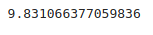

# Общие выводы

В результатае sMAPE получился равным 9.27.

При сравнни с константной моделью, можно сделать вывод что модель не является эффективной. Это значит, что в данной задаче нужно пременять более сложные алгоритмы машинного обучения.